### Workbook for calculating journey distances for Rwanda catchment survey respondents
Week of July 7, 2025
<br>
Author: Adele Birkenes

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import os
import matplotlib.pyplot as plt
import numpy as np

Task 1: Read in Rwanda bridge sites (df), catchment survey data (df), and village boundaries (gdf)

In [13]:
synced_catchment_path = "../../synced-data/catchment-analysis"
synced_population_path = "../../synced-data/population-exploration"
graphics_path = "../../notebooks/catchment-analysis/graphics"

# Rwanda bridge sites
Rwanda_bridges_fp = os.path.join(synced_catchment_path, "Rwanda_catchment_bridge_sites.csv")
Rwanda_bridges = pd.read_csv(Rwanda_bridges_fp, encoding='ISO-8859-1') # Note: This encoding accommodates special characters)

# Rwanda catchment survey data
Rwanda_catchment_surveys_fp = os.path.join(synced_catchment_path, "Rwanda_catchment_all_surveys.csv")
Rwanda_catchment_surveys = pd.read_csv(Rwanda_catchment_surveys_fp, encoding='ISO-8859-1')

# Rwanda village boundaries
Rwanda_village_boundaries_fp = os.path.join(synced_population_path, "Rwanda Village Boundaries/Village.shp")
Rwanda_village_boundaries = gpd.read_file(Rwanda_village_boundaries_fp, encoding='ISO-8859-1')

In [14]:
# Minimal data cleaning - ensure that destination admin codes in catchment survey data do not have decimal points
Rwanda_catchment_surveys['Destination - Admin Code'] = Rwanda_catchment_surveys['Destination - Admin Code'].astype(str).str.replace('.0', '', regex=False)

Task 2: Convert bridge sites dataframe to geodataframe that has custom Rwanda TM CRS copied from village boundaries geodataframe

In [15]:
# Convert bridge sites dataframe to geodataframe that has custom Rwanda TM CRS copied from village boundaries geodataframe
def map_bridges(bridges, bridges_lat, bridges_lon, village_boundaries):

    # Check CRS of village boundaries gdf
    print(f'The CRS of the village boundaries gdf is: {village_boundaries.crs}')

    # Create lat/lon variables
    lon = bridges[bridges_lon]
    lat = bridges[bridges_lat]

    # Create gdf of bridges data by converting lat/lon values to list of Shapely Point objects
    bridge_points = gpd.GeoDataFrame(bridges, geometry=gpd.points_from_xy(x=lon, y=lat), crs='EPSG:4326')

    # Set CRS of bridges gdf to CRS of village boundaries gdf
    bridge_points.to_crs(village_boundaries.crs, inplace=True)

    # Check that reprojection was successful
    print(f'The CRS of the bridges gdf is: {bridge_points.crs}')
    
    return bridge_points

bridge_points = map_bridges(bridges = Rwanda_bridges,
                            bridges_lat = "Lat",
                            bridges_lon = "Long",
                            village_boundaries = Rwanda_village_boundaries)

The CRS of the village boundaries gdf is: PROJCS["TM_Rwanda",GEOGCS["ITRF2005",DATUM["International_Terrestrial_Reference_Frame_2005",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6896"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",500000],PARAMETER["false_northing",5000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
The CRS of the bridges gdf is: PROJCS["TM_Rwanda",GEOGCS["ITRF2005",DATUM["International_Terrestrial_Reference_Frame_2005",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6896"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",30],PARAMETER["scale_factor",0.9999],PARAMETER["false_

Task 3: Calculate & assign centroids to all polygons in village boundaries geodataframe

In [16]:
# Calculate the centroid of each village polygon
def calculate_village_centroids(village_gdf):
    village_gdf['centroid'] = village_gdf.geometry.centroid
    return village_gdf

# Apply the function to calculate centroids
village_centroids = calculate_village_centroids(village_gdf = Rwanda_village_boundaries)

# Print the first few rows of one of the centroids geodataframes to verify
print(village_centroids.head())

     District Village_ID Cell_ID Sector_ID Distr_ID Prov_ID        Name  \
0  Nyarugenge   11010102  110101      1101       11       1     Gihanga   
1  Nyarugenge   11010103  110101      1101       11       1  Iterambere   
2  Nyarugenge   11010104  110101      1101       11       1       Izuba   
3  Nyarugenge   11010105  110101      1101       11       1  Nyaburanga   
4  Nyarugenge   11010106  110101      1101       11       1    Nyenyeri   

        Cell  Sector                      Province  \
0  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   
1  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   
2  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   
3  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   
4  Akabahizi  Gitega  Kigali Town/Umujyi wa Kigali   

                                            geometry  \
0  POLYGON Z ((505804.107 4784697.395 0, 505808.8...   
1  POLYGON Z ((505725.35 4785070.964 0, 505750.76...   
2  POLYGON Z ((505689.339 4785047.225 0, 505712.2...   


Task 4: Assign centroids to each catchment survey response by matching the admin codes from the catchment survey data to the admin codes in the village boundaries geodataframe

In [ ]:
# Assign centroids for home villages to catchment survey data
def assign_home_village_centroids(survey_data, village_centroids):
    
    # Ensure both columns are of the same type before merging
    survey_data['Home Village - Admin Code'] = survey_data['Home Village - Admin Code'].astype(str)
    village_centroids['Village_ID'] = village_centroids['Village_ID'].astype(str)

    # Join centroids to survey data using shared admin codes; store centroids in a new column
    survey_data = survey_data.merge(village_centroids[['Village_ID', 'centroid']],
                                    left_on='Home Village - Admin Code',
                                    right_on='Village_ID',
                                    how='left')

    # Rename centroid column
    survey_data.rename(columns={'centroid': 'home_centroid'}, inplace=True)

    return survey_data

# Apply the function
Rwanda_catchment_surveys = assign_home_village_centroids(survey_data = Rwanda_catchment_surveys, village_centroids = village_centroids)

# Print the first few rows to verify
print(Rwanda_catchment_surveys.head())

  Bridge Site Bridge Survey: Created Date Bridge Survey: Bridge Survey Name  \
0      Gasasa                  10/02/2021          Bridge Survey - 00004615   
1      Gasasa                  10/12/2021          Bridge Survey - 00004711   
2      Gasasa                  10/12/2021          Bridge Survey - 00004710   
3      Gasasa                  10/12/2021          Bridge Survey - 00004709   
4      Gasasa                  10/12/2021          Bridge Survey - 00004708   

  Origin Origin - Other  Origin - Admin Code Destination Destination - Other  \
0    NaN            NaN                  NaN       Other            Nyamweru   
1    NaN            NaN                  NaN      Gasasa                 NaN   
2    NaN            NaN                  NaN      Gasasa                 NaN   
3    NaN            NaN                  NaN      Gasasa                 NaN   
4    NaN            NaN                  NaN      Gasasa                 NaN   

  Destination - Admin Code Home Village  ...

In [ ]:
# Assign centroids for destination villages to catchment survey data
def assign_destination_village_centroids(survey_data, village_centroids):

    # Ensure both columns are of the same type before merging
    survey_data['Destination - Admin Code'] = survey_data['Destination - Admin Code'].astype(str)
    village_centroids['Village_ID'] = village_centroids['Village_ID'].astype(str)

    # Join centroids to survey data using shared admin codes; store centroids in a new column
    survey_data = survey_data.merge(village_centroids[['Village_ID', 'centroid']],
                                    left_on='Destination - Admin Code',
                                    right_on='Village_ID',
                                    how='left')

    # Rename centroid column
    survey_data.rename(columns={'centroid': 'destination_centroid'}, inplace=True)

    return survey_data

# Apply the function
Rwanda_catchment_surveys = assign_destination_village_centroids(survey_data = Rwanda_catchment_surveys, village_centroids = village_centroids)

# Print the first few rows to verify
print(Rwanda_catchment_surveys.head())

  Bridge Site Bridge Survey: Created Date Bridge Survey: Bridge Survey Name  \
0      Gasasa                  10/02/2021          Bridge Survey - 00004615   
1      Gasasa                  10/12/2021          Bridge Survey - 00004711   
2      Gasasa                  10/12/2021          Bridge Survey - 00004710   
3      Gasasa                  10/12/2021          Bridge Survey - 00004709   
4      Gasasa                  10/12/2021          Bridge Survey - 00004708   

  Origin Origin - Other  Origin - Admin Code Destination Destination - Other  \
0    NaN            NaN                  NaN       Other            Nyamweru   
1    NaN            NaN                  NaN      Gasasa                 NaN   
2    NaN            NaN                  NaN      Gasasa                 NaN   
3    NaN            NaN                  NaN      Gasasa                 NaN   
4    NaN            NaN                  NaN      Gasasa                 NaN   

  Destination - Admin Code Home Village  ...

Task 5: Assign bridge coordinates to catchment survey responses

In [20]:
# Assign bridge coordinates to catchment survey data
def assign_bridge_coordinates(survey_data, bridge_points):

    # Ensure both columns are of the same type before merging
    survey_data['Bridge Site'] = survey_data['Bridge Site'].astype(str)
    bridge_points['Bridge Name'] = bridge_points['Bridge Name'].astype(str)

    # Join bridge coordinates to survey data using shared bridge names
    survey_data = survey_data.merge(bridge_points[['Bridge Name', 'geometry']],
                                    left_on='Bridge Site',
                                    right_on='Bridge Name',
                                    how='left')

    # Rename coordinates column
    survey_data.rename(columns={'geometry': 'bridge_coordinates'}, inplace=True)

    return survey_data

# Apply the function
Rwanda_catchment_surveys = assign_bridge_coordinates(survey_data = Rwanda_catchment_surveys, bridge_points = bridge_points)

# Print the first few rows to verify
print(Rwanda_catchment_surveys.head())

  Bridge Site Bridge Survey: Created Date Bridge Survey: Bridge Survey Name  \
0      Gasasa                  10/02/2021          Bridge Survey - 00004615   
1      Gasasa                  10/12/2021          Bridge Survey - 00004711   
2      Gasasa                  10/12/2021          Bridge Survey - 00004710   
3      Gasasa                  10/12/2021          Bridge Survey - 00004709   
4      Gasasa                  10/12/2021          Bridge Survey - 00004708   

  Origin Origin - Other  Origin - Admin Code Destination Destination - Other  \
0    NaN            NaN                  NaN       Other            Nyamweru   
1    NaN            NaN                  NaN      Gasasa                 NaN   
2    NaN            NaN                  NaN      Gasasa                 NaN   
3    NaN            NaN                  NaN      Gasasa                 NaN   
4    NaN            NaN                  NaN      Gasasa                 NaN   

  Destination - Admin Code Home Village  ...

Task 6: Calculate Euclidean distance between home/destination centroids and bridge sites for each catchment survey response. Calculate home and destination distances separately and then sum for total distance

In [22]:
# Calculate journey distances for survey respondents
def calculate_journey_distances(survey_data):

    # Calculate distance from home village centroid to bridge coordinates
    survey_data['home_to_bridge_distance'] = survey_data.apply(
        lambda row: row['home_centroid'].distance(row['bridge_coordinates'])
        if row['home_centroid'] is not None and row['bridge_coordinates'] is not None
        else np.nan, axis=1)

    # Calculate distance from bridge coordinates to destination village centroid
    survey_data['bridge_to_destination_distance'] = survey_data.apply(
        lambda row: row['bridge_coordinates'].distance(row['destination_centroid'])
        if row['bridge_coordinates'] is not None and row['destination_centroid'] is not None
        else np.nan, axis=1)

    survey_data['total_distance'] = survey_data['home_to_bridge_distance'] + survey_data['bridge_to_destination_distance']

    return survey_data

# Apply the function
Rwanda_catchment_surveys = calculate_journey_distances(survey_data = Rwanda_catchment_surveys)

# Print the first few rows to verify
print(Rwanda_catchment_surveys.head())

  Bridge Site Bridge Survey: Created Date Bridge Survey: Bridge Survey Name  \
0      Gasasa                  10/02/2021          Bridge Survey - 00004615   
1      Gasasa                  10/12/2021          Bridge Survey - 00004711   
2      Gasasa                  10/12/2021          Bridge Survey - 00004710   
3      Gasasa                  10/12/2021          Bridge Survey - 00004709   
4      Gasasa                  10/12/2021          Bridge Survey - 00004708   

  Origin Origin - Other  Origin - Admin Code Destination Destination - Other  \
0    NaN            NaN                  NaN       Other            Nyamweru   
1    NaN            NaN                  NaN      Gasasa                 NaN   
2    NaN            NaN                  NaN      Gasasa                 NaN   
3    NaN            NaN                  NaN      Gasasa                 NaN   
4    NaN            NaN                  NaN      Gasasa                 NaN   

  Destination - Admin Code Home Village  ...

In [23]:
# Calculate average journey distance for each bridge site
def calculate_average_distances(survey_data):
    return survey_data.groupby('Bridge Site')['total_distance'].mean().reset_index()

# Apply the function
average_distances = calculate_average_distances(survey_data = Rwanda_catchment_surveys)

# Print the results
print(average_distances)

         Bridge Site  total_distance
0           Gahororo     2911.360582
1             Gasasa     8841.029146
2          Kanyarira    14346.070588
3            Muhembe    14626.028068
4           Muregeya     8514.903048
5        Mutiwingoma     5186.731435
6         Nyarusange    29119.650855
7            Rugeshi    22960.340480
8           Ruharazi     2694.966454
9          Rwamamara     4678.358303
10          Rwimvubu     5576.463964
11  Uwumugeti-Kigusa     2373.613822


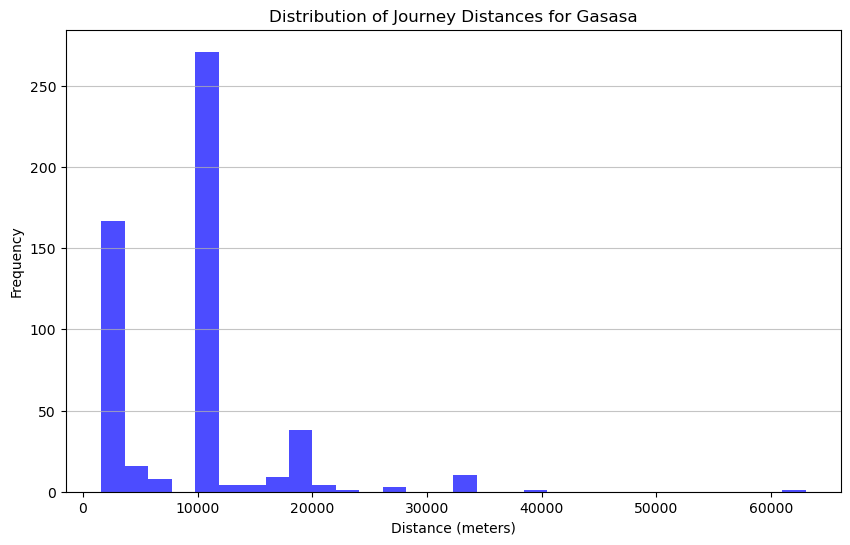

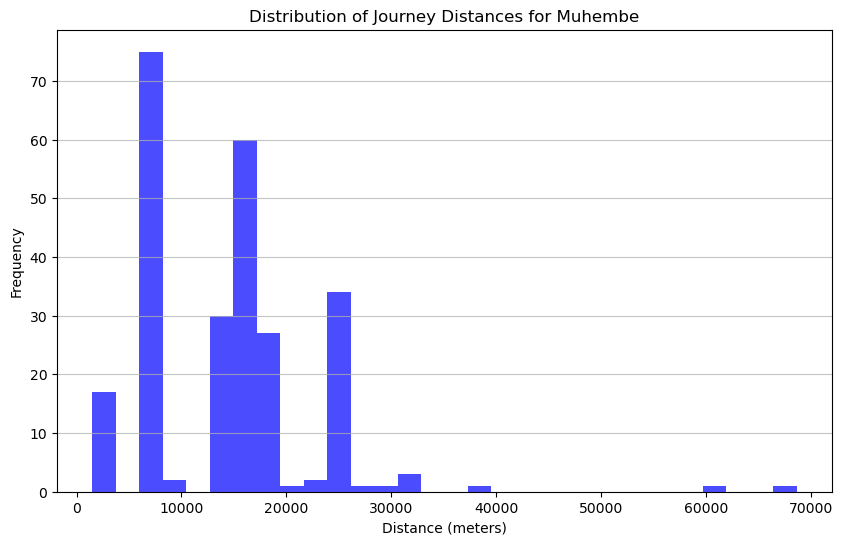

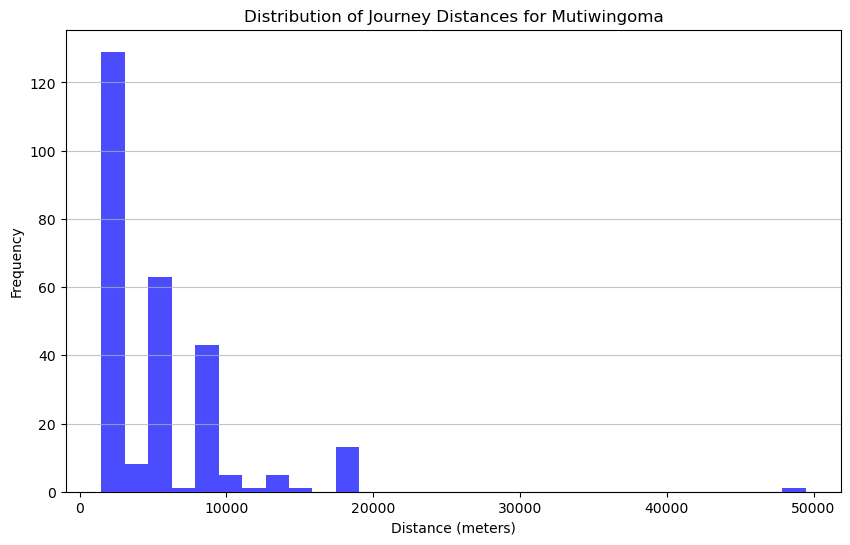

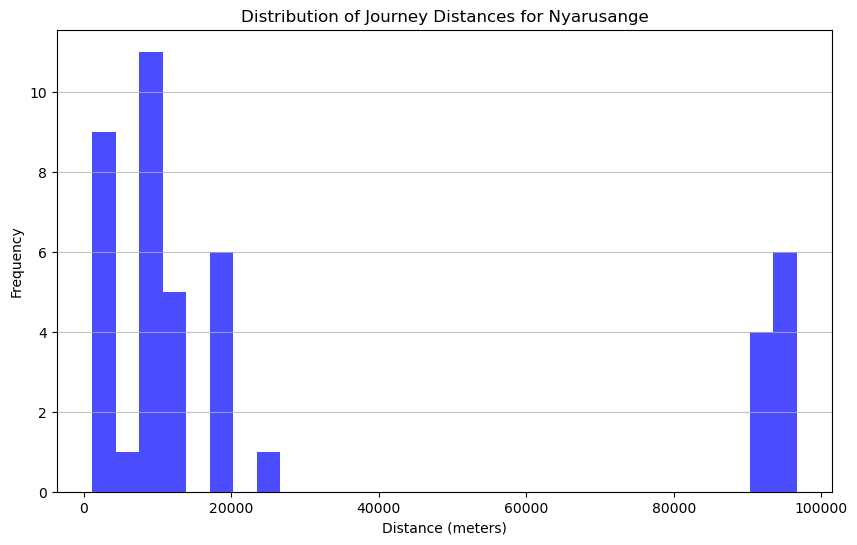

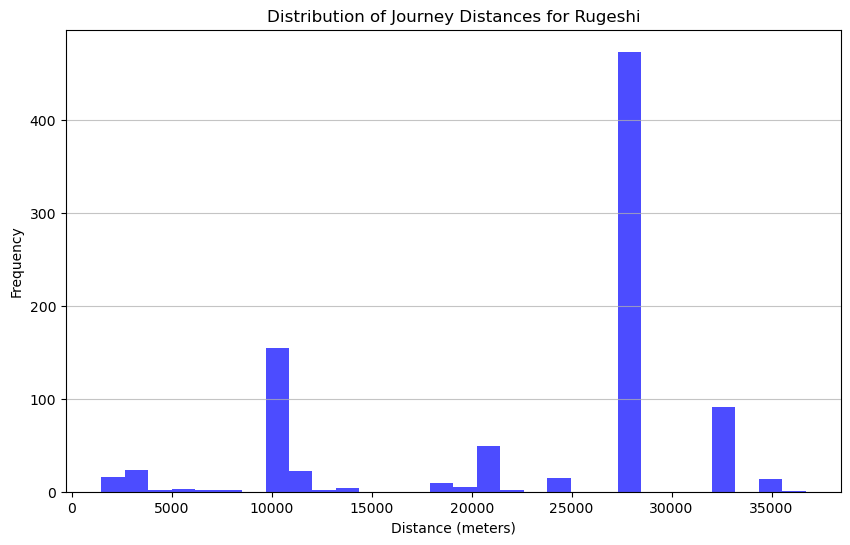

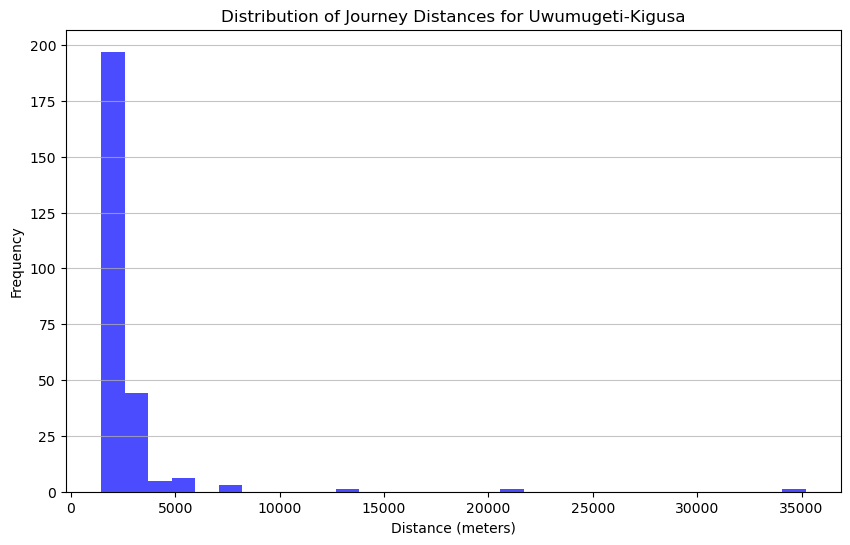

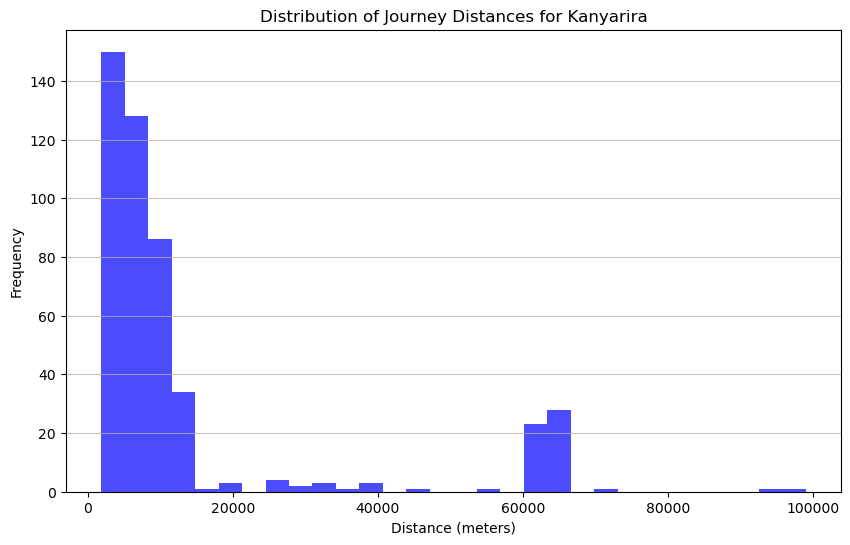

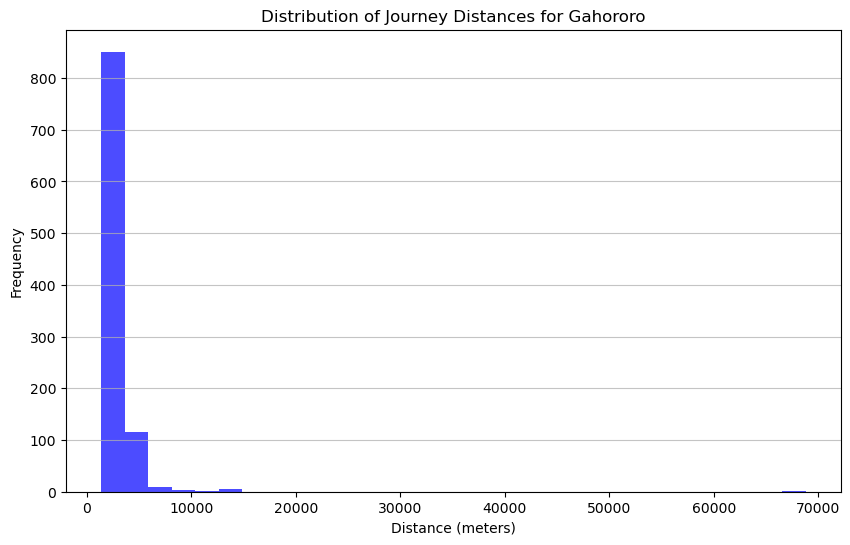

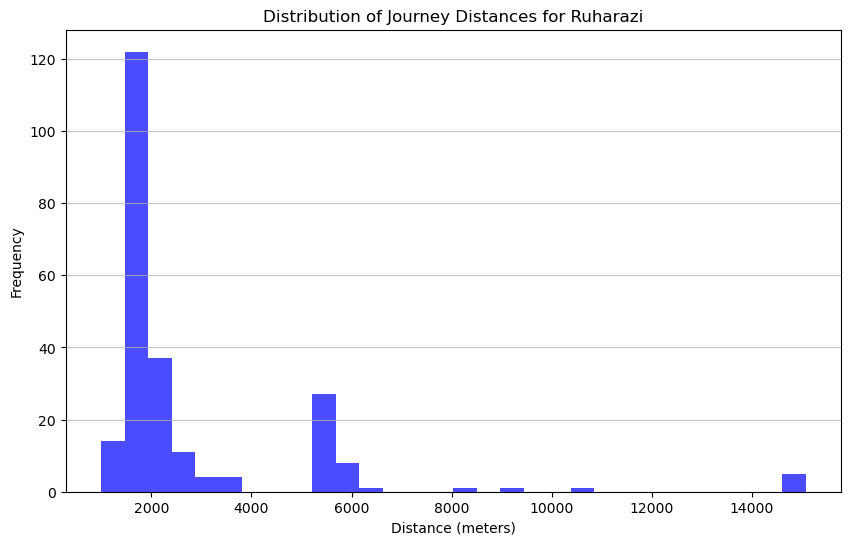

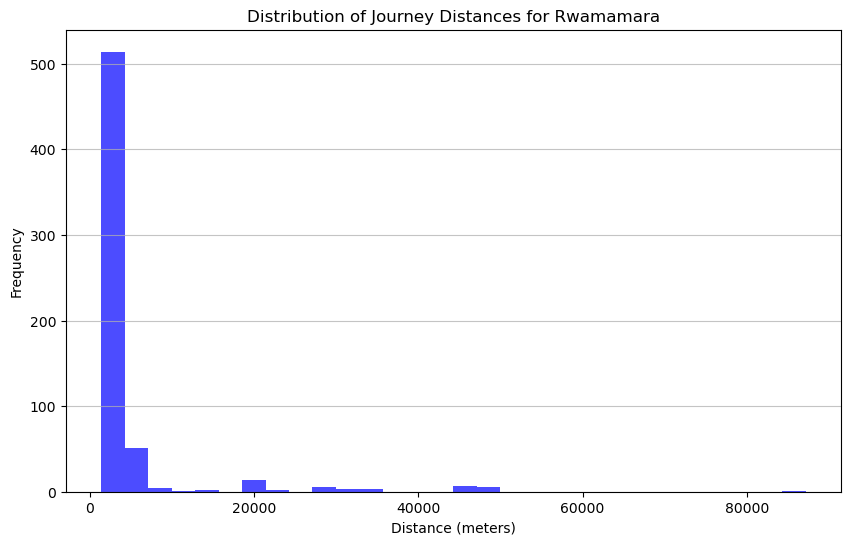

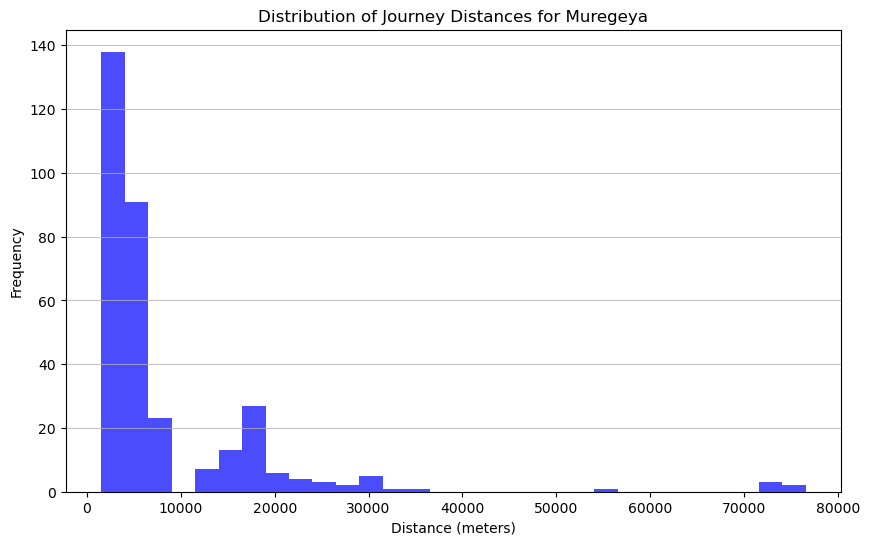

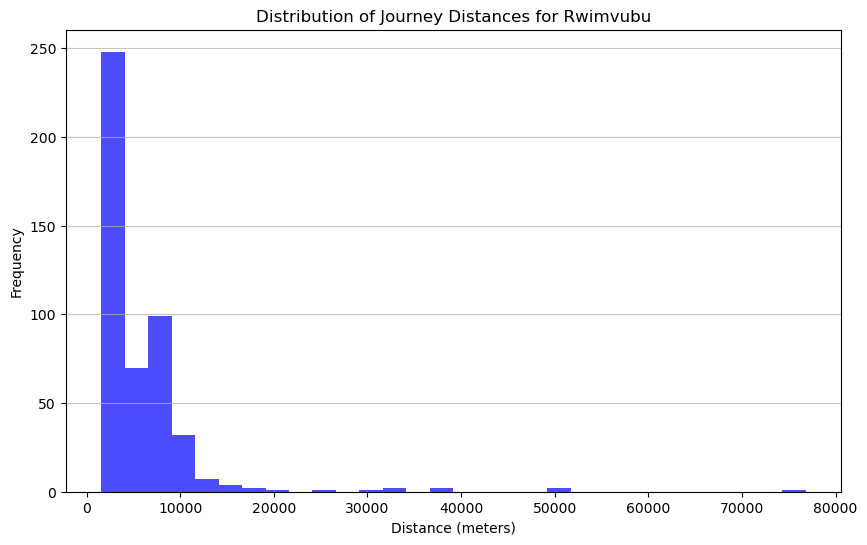

In [ ]:
# Create distribution plots of journey distances for each bridge site
def plot_journey_distance_distribution(survey_data, bridge_sites):
    for bridge in bridge_sites:
        plt.figure(figsize=(10, 6))
        subset = survey_data[survey_data['Bridge Site'] == bridge]
        plt.hist(subset['total_distance'].dropna(), bins=30, alpha=0.7, color='blue')
        plt.title(f'Distribution of Journey Distances for {bridge}')
        plt.xlabel('Distance (meters)')
        plt.ylabel('Number of Survey Respondents')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

# Apply the plotting function
plot_journey_distance_distribution(survey_data = Rwanda_catchment_surveys, bridge_sites = Rwanda_catchment_surveys['Bridge Site'].unique())